# EVSE Market Analysis
Note: This is run every *Wednesday*, and therefore will not work properly if run on any other day. Therefore, a switch was added so that it can be run using pre-defined datasets that were pulled from the NREL API previously (using this code). **Set the below switch (test_run_switch) to True if running this code without 2 weeks of past data.**

In [1]:
test_run_switch = False

In [2]:
import requests
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter, MaxNLocator
import seaborn as sns
import xlsxwriter

sns.set(rc={"figure.figsize": (12, 9)}, style='ticks', context='talk')

In [3]:
data = requests.get('https://developer.nrel.gov/api/alt-fuel-stations/v1.json?access=public&status=E&fuel_type=ELEC&api_key=gICMTaBKdZnvi39aqPrUuye1jmFAaCEMngZYKVTN&format=JSON')
data = data.json()
# data = json.loads(data.text)
data = pd.DataFrame(data['fuel_stations'])

These functions do basic printouts or dataframe manipulations that I didn't want coded 2-3 times

In [4]:
def charge_level_summary(df):
    evse_counts = df.fillna(0).groupby('State')[['Level 1', 'Level 2', 'DC Fast Charge']].sum()
    evse_counts_melt = evse_counts.reset_index().melt(id_vars=['State'], var_name='Charge Level', value_name='Number of plugs')
    evse_plot= evse_counts_melt.groupby(['State', 'Charge Level'])['Number of plugs'].sum().unstack(level=1).sort_values('Level 2', ascending=False)[['Level 1', 'Level 2', 'DC Fast Charge']]
    tesla_evse = df[(df['EV Network'] == 'Tesla')&(df['DC Fast Charge'] > 0)]
    print('Station count (not including private stations):')
    print('{} DC Fast Chargers ({} plugs, {} plugs per station)'.format(df['DC Fast Charge'].count(), evse_plot.sum()['DC Fast Charge'].astype(int), (df['DC Fast Charge'].sum()/df['DC Fast Charge'].count()).round(2)))
    print('{} Level 2 Chargers ({} plugs, {} plugs per station))'.format(df['Level 2'].count(), evse_plot.sum()['Level 2'].astype(int), (df['Level 2'].sum()/df['Level 2'].count()).round(2)))
    print('{} Level 1 Chargers ({} plugs, {} plugs per station))'.format(df['Level 1'].count(), evse_plot.sum()['Level 1'].astype(int), (df['Level 1'].sum()/df['Level 1'].count()).round(2)))
    print('{} Tesla Superchargers ({} plugs, {} plugs per station))'.format(tesla_evse.shape[0], tesla_evse['DC Fast Charge'].sum().astype(int), (tesla_evse['DC Fast Charge'].sum()/tesla_evse['DC Fast Charge'].count()).round(2)))
    print('{} total plugs'.format(evse_plot.sum()['Level 1'].astype(int)+evse_plot.sum()['Level 2'].astype(int)+evse_plot.sum()['DC Fast Charge'].astype(int)))
    print('{} total chargers'.format(df.shape[0]))
def plugs_by_state(df, get='plugs'):
    if get=='stations':
        evse_counts = df.groupby('State')[['Level 1', 'Level 2', 'DC Fast Charge']].count()
        return evse_counts
    else:
        evse_counts = df.fillna(0).groupby('State')[['Level 1', 'Level 2', 'DC Fast Charge']].sum()
        return evse_counts

Pull in the station count data from the previous 2 weeks for comparison (*_prev_2* and *_prev*), and grab/rename the relevant columns to create this weeks' dataset. Requires previous two weeks of EVSE market data (CSVs).

In [5]:
if test_run_switch:
    all_stations_prev_2 = pd.read_csv("alt_fuel_stations (February 20 2019).csv")
    all_stations_prev = pd.read_csv("alt_fuel_stations (February 27 2019).csv")
    all_stations = pd.read_csv("alt_fuel_stations (March 06 2019).csv")
else:
    all_stations_prev_2 = pd.read_csv("alt_fuel_stations ({}).csv".format((dt.datetime.today() - dt.timedelta(days=14)).strftime("%B %d %Y")))
    all_stations_prev = pd.read_csv("alt_fuel_stations ({}).csv".format((dt.datetime.today() - dt.timedelta(days=7)).strftime("%B %d %Y")))
    all_stations = data[['state','ev_dc_fast_num','ev_level1_evse_num', 'ev_level2_evse_num','ev_network']].rename(columns={'state':'State',
                                        'ev_level1_evse_num':'Level 1', 'ev_level2_evse_num':'Level 2', 'ev_dc_fast_num':'DC Fast Charge',
                                        'ev_network':'EV Network'})

stations_list = [all_stations_prev_2, all_stations_prev, all_stations]

Save this week's dataset to csv.

In [6]:
if not test_run_switch:
    all_stations.to_csv('alt_fuel_stations ({}).csv'.format(dt.datetime.today().strftime("%B %d %Y")))

Print out some quick info for comparison (and dummy checking)

In [7]:
print('\t Last week')
charge_level_summary(all_stations_prev)
print('\n\tThis week')
charge_level_summary(all_stations)
print('\n{} additional stations since last time'.format(all_stations.shape[0] - all_stations_prev.shape[0]))

	 Last week
Station count (not including private stations):
2693 DC Fast Chargers (10017 plugs, 3.72 plugs per station)
19183 Level 2 Chargers (49816 plugs, 2.6 plugs per station))
860 Level 1 Chargers (1775 plugs, 2.06 plugs per station))
618 Tesla Superchargers (5667 plugs, 9.17 plugs per station))
61608 total plugs
21176 total chargers

	This week
Station count (not including private stations):
2702 DC Fast Chargers (10046 plugs, 3.72 plugs per station)
19236 Level 2 Chargers (50055 plugs, 2.6 plugs per station))
832 Level 1 Chargers (1727 plugs, 2.08 plugs per station))
618 Tesla Superchargers (5667 plugs, 9.17 plugs per station))
61828 total plugs
21229 total chargers

53 additional stations since last time


Generate dataframes that show the change in number of plugs (*delta_plugs*) and stations (*delta_stations*) by state and charge level/speed.

In [8]:
delta_plugs = ((plugs_by_state(all_stations,'plugs') - plugs_by_state(all_stations_prev,'plugs')).replace(0, np.nan).dropna(how='all', axis=0).fillna('-'))
delta_stations = ((plugs_by_state(all_stations,'stations') - plugs_by_state(all_stations_prev,'stations')).replace(0, np.nan).dropna(how='all', axis=0))
delta_stations = delta_stations.astype('float').fillna('-')
delta_stations.to_csv('{}_deltstation.csv'.format(dt.date.today()))

Create a deltstation.xlsx file containing the delta_stations data and apply formatting to deltstation.xlsx file using xlsxwriter.

In [9]:
# This function basically finds where the data will be written in the Excel sheet (minus index and headers, which is why we start at B2) 
# based on the length of the dataframe and the number of columns.  Also returns range where index will be written and columns where headers,data, and index will be written.
def get_data_range(data):
    col_list = list('BCDEFGHIJKLMNOPQRSTUVWXYZ')
    # Maps col numbers to letters
    col_map = dict(zip([*range(2, len(col_list) + 2)], col_list))
    # Cell where formatting ends
    end_cell = col_map[len(data.columns) + 1]+str(len(data.index) + 1)
    return 'A1:' + end_cell, 'B2:' + end_cell, 'A2:A:' + str(len(data.index) + 1), 'A:' + end_cell[0]

entire_range, data_range, index_range, col_range = get_data_range(delta_stations)

# Create a Pandas Excel writer using XlsxWriter as the engine.
#writer = pd.ExcelWriter('test.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
# Do not write pandas headers and start writing delta_stations data in row 1 of the xlsx sheet
#delta_stations.to_excel(writer, sheet_name='Sheet1', startrow = 1, header = False)

# Get the xlsxwriter objects from the dataframe writer object.
#workbook  = writer.book
#worksheet = writer.sheets['Sheet1']


workbook = xlsxwriter.Workbook('{}_deltstation.xlsx'.format(dt.date.today()))
worksheet = workbook.add_worksheet()

# Set default row height and col width
worksheet.set_default_row(20)
worksheet.set_column(col_range, 10)

# Make headers a bit more padded.
worksheet.set_row(0, 35)

# Crate a format for the headers
header_format = workbook.add_format({
    'text_wrap': True,
    'valign': 'vcenter',
    'align': 'center',
    'border': 1})

index_format = workbook.add_format({
    'valign': 'vcenter',
    'border': 1})

data_format =  workbook.add_format({
    'valign': 'vcenter',
    'align': 'center',
    'border': 1})

plain_border = workbook.add_format({
    'border':1
})

# Set formats for increases and decreases in stations.  For increases, format will be green fill with dark green text. 
# For decreases, red fill with dark red text. Cells where there is neither increase nor decrease will have black text and white fill.
increase_in_stations_format = workbook.add_format({'bg_color': '#C6EFCE',
                               'font_color': '#006100',
                               'border': 1,
                               'align': 'center',
                               'valign': 'vcenter'})
decrease_in_stations_format = workbook.add_format({'bg_color': '#FFC7CE',
                               'font_color': '#9C0006',
                               'border': 1,
                               'align': 'center',
                               'valign': 'vcenter'})
neither_format = workbook.add_format({'bg_color': '#ffffff',
                               'font_color': '#000000',
                               'border': 1,
                               'align': 'center',
                               'valign': 'vcenter'})

# Write the column headers with the defined header_format.  Column headers will start in cell B1.
worksheet.write_row('B1', list(delta_stations.columns.values), header_format)
    
# Write the index with the defined index_format. The index will start in cell A2.
worksheet.write_column('A2', list(delta_stations.index.values), index_format)


# Reformat the delta_stations data into a list of lists (where each list is a dataframe row) so that each list can be written as a row in excel using 
# xlsxwriter.  Need to use this method instad of pd.to_excel(..., engine = 'xlsxwriter') because formatting (i.e., centering) is not supported with 
# pd.to_excel(). Alignment is one of the only types of formatting that MUST be applied as the data is written -- cannot be applied afterwards using 
# conditional_format().
delta_stations_f = []
for i in range(len(delta_stations)):
    delta_stations_f.append(list(delta_stations.iloc[i]))

# Write the rows to excel using the data_format.
for i in range(2, len(delta_stations)+ 2):
    worksheet.write_row('B'+ str(i), delta_stations_f[i-2], data_format)
    
# Format the data.  Add borders and conditional formatting.
worksheet.conditional_format(entire_range, {'type': 'blanks', 'format': plain_border})
worksheet.conditional_format(entire_range, {'type': 'non_blanks', 'format': plain_border})
worksheet.conditional_format(data_range, {'type': 'cell', 'criteria':'equal to', 'value': '"-"', 'format': neither_format})
worksheet.conditional_format(data_range, {'type': 'cell', 'criteria': '>', 'value': 0, 'format': increase_in_stations_format})
worksheet.conditional_format(data_range, {'type': 'cell', 'criteria': '<', 'value': 0, 'format': decrease_in_stations_format})

# Close and save workbook.
workbook.close()

C:\Users\EBarnard\AppData\Local\Continuum\anaconda3-1\lib\site-packages\xlsxwriter\worksheet.py:2066: UserWarning: Unknown value 'non_blanks' for parameter 'type' in conditional_format()
  "in conditional_format()" % options['type'])


Generate the station count dataframes that are used for plotting

In [10]:
evse_counts = all_stations.fillna(0).groupby('State')[['Level 1', 'Level 2', 'DC Fast Charge']].sum()
evse_counts_melt = evse_counts.reset_index().melt(id_vars=['State'], var_name='Charge Level', value_name='Number of plugs')
evse_counts_melt = evse_counts_melt[~evse_counts_melt['State'].isin(['Puerto Rico'])]
evse_plot= evse_counts_melt.groupby(['State', 'Charge Level'])['Number of plugs'].sum().unstack(level=1).sort_values('Level 2', ascending=False)[['Level 1', 'Level 2', 'DC Fast Charge']]

Generate the plug count dataframes (basically only used for the CA shares calculated in the next cell . . . )

In [11]:
plugs_by_state = evse_counts_melt.groupby('State')['Number of plugs'].sum()
state_shares = (evse_counts_melt.groupby(['State', 'Charge Level'])['Number of plugs'].sum().unstack(level=1)/evse_counts_melt.groupby(['State', 'Charge Level'])['Number of plugs'].sum().unstack(level=1).sum())*100
state_counts = evse_counts_melt.groupby(['State', 'Charge Level'])['Number of plugs'].sum().unstack(level=1).sort_values('Level 2', ascending=False)

Print out the CA shares that are directly copy/pasted into the caption for the EVSE figure in the AFV News Update doc.

In [12]:
print('CA Shares (plug counts):')
ca_shares_str = "{:.1f}% ({}), {:.1f}% ({}), and {:.1f}% ({})".format(state_shares.loc['CA',:]['Level 1'],int(state_counts.loc['CA',:]['Level 1']),
                                                    state_shares.loc['CA',:]['Level 2'],int(state_counts.loc['CA',:]['Level 2']),
                                                    state_shares.loc['CA',:]['DC Fast Charge'],int(state_counts.loc['CA',:]['DC Fast Charge']))
print(ca_shares_str)

try:
    ca_shares = pd.read_csv('all_CA_shares.csv', ';')[['date', 'text']].set_index('date', drop = True)
    ca_shares.loc[str(dt.date.today())] = ca_shares_str
    ca_shares.to_csv('all_CA_shares.csv', ';')
except FileNotFoundError:
    ca_shares = pd.DataFrame({'date':[str(dt.date.today())], 'text': [ca_shares_str]})
    ca_shares.to_csv('all_CA_shares.csv', ';')

CA Shares (plug counts):
22.2% (383), 32.9% (16476), and 28.8% (2894)


C:\Users\EBarnard\AppData\Local\Continuum\anaconda3-1\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\EBarnard\AppData\Local\Continuum\anaconda3-1\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


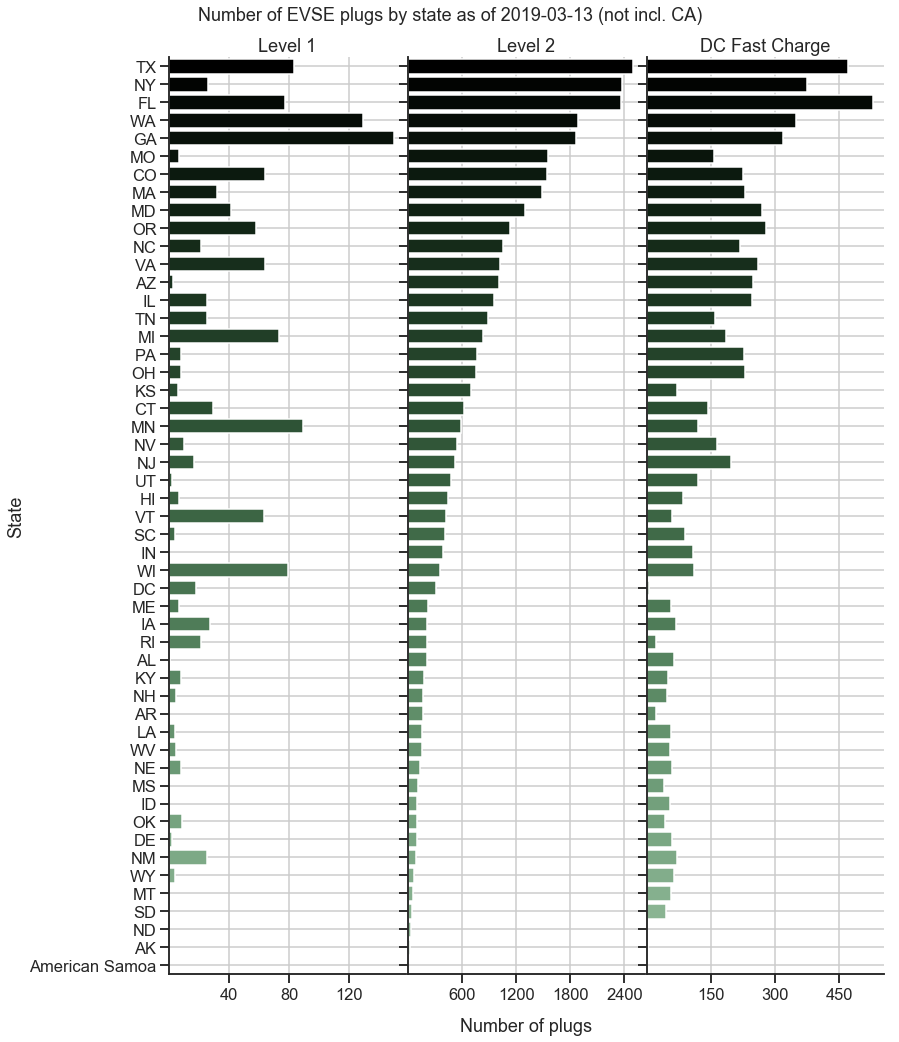

In [13]:
sns.set_style('ticks')
g = sns.factorplot(x='Number of plugs', y='State', col='Charge Level', data=evse_counts_melt[evse_counts_melt['State']!='CA'].sort_values('Number of plugs', ascending=False), 
               col_order=['Level 1', 'Level 2', 'DC Fast Charge'], kind='bar', aspect=0.3, size=14, 
                   palette=sns.cubehelix_palette(52, start=2, rot=0, dark=0, light=.7, reverse=True), sharex=False)
g.set_titles('{col_name}')
for axis in g.axes[0]:
    axis.xaxis.set_major_locator(MaxNLocator(prune='both'))
    axis.locator_params(axis='x', nbins=5)
    axis.grid(axis='both')
g.axes[0][0].set_xlabel('')
g.axes[0][1].set_xlabel('Number of plugs', labelpad=15)
g.axes[0][2].set_xlabel('')
plt.subplots_adjust(wspace=0.01)
plt.suptitle('Number of EVSE plugs by state as of {} (not incl. CA)'.format(dt.date.today()), fontsize=18, y=1.02)
plt.savefig(f'EVSE_bar_chart_{str(dt.date.today())}') # Must match news scraper format
plt.show()

### Notes:
* For the **requests** package: https://stackoverflow.com/questions/25067580/passing-web-data-into-beautiful-soup-empty-list
* BeautifulSoup documentation: https://www.crummy.com/software/BeautifulSoup/bs4/doc/
* NREL API: https://developer.nrel.gov/docs/transportation/alt-fuel-stations-v1/all/
* strftime reference: http://strftime.org/